Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


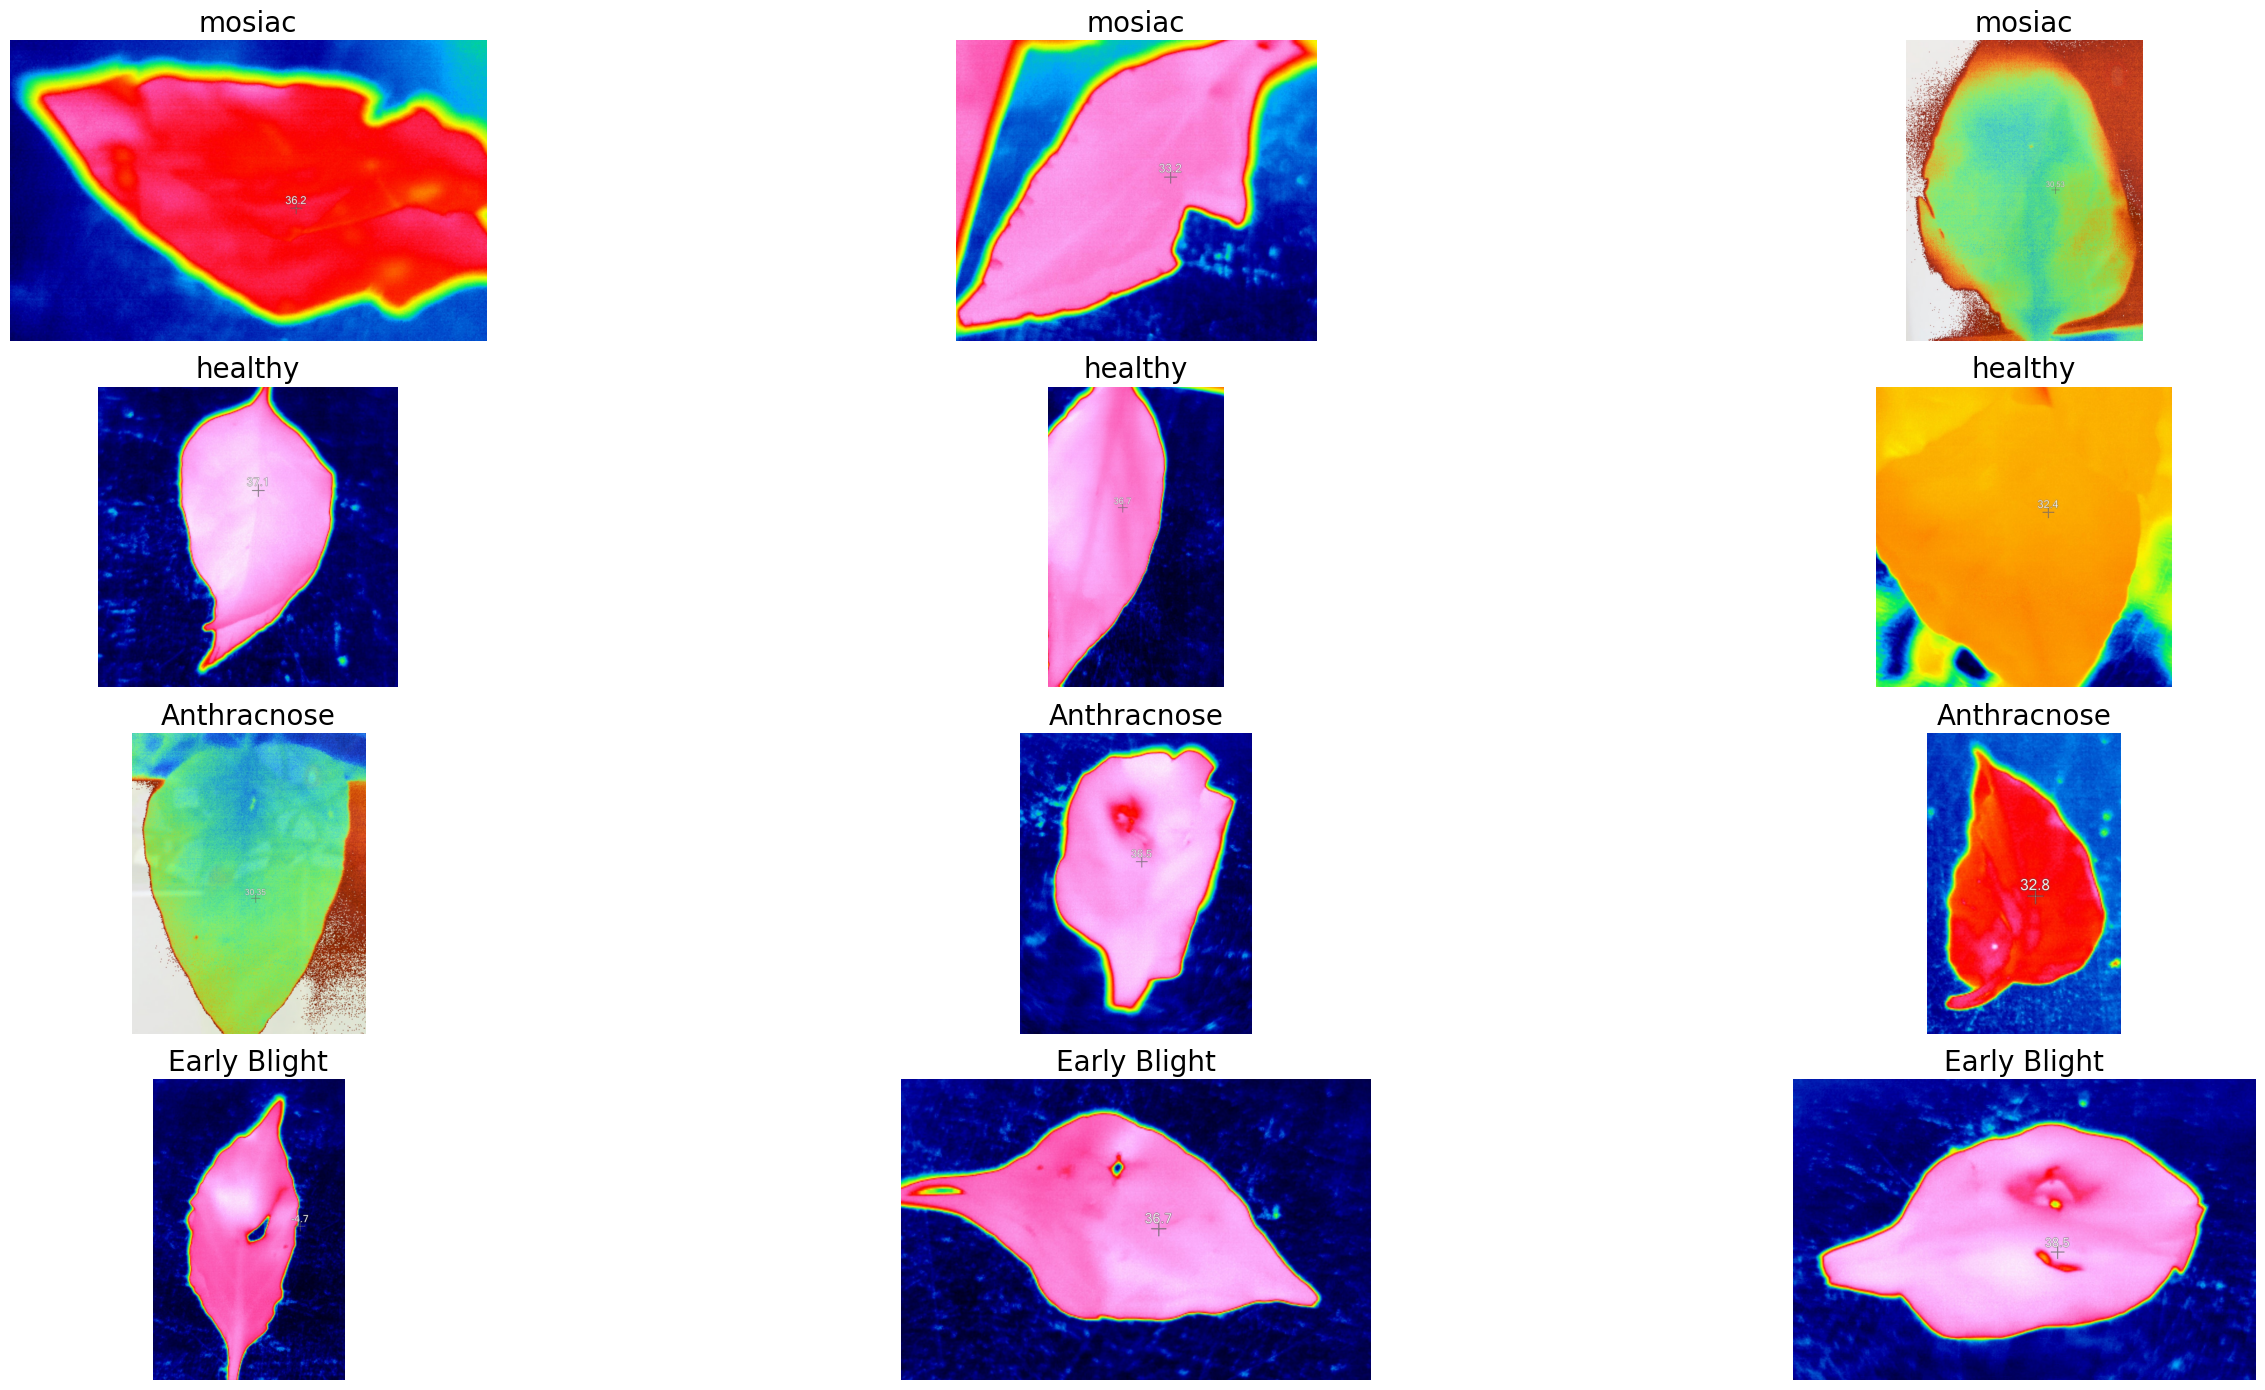

Found 508 images belonging to 4 classes.
Found 125 images belonging to 4 classes.
Epoch 1/100
 1/16 ━━━━━━━━━━━━━━━━━━━━ 16:19 65s/step - accuracy: 0.1429 - loss: 3.1793

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adadelta
import warnings

warnings.filterwarnings('ignore')
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')
# Define dataset paths
dataset_path = '/content/drive/MyDrive/dataset/train'

# List all subdirectories (assumes subdirectories are class labels)
class_directories = [os.path.join(dataset_path, sub_dir) for sub_dir in os.listdir(dataset_path)]
class_labels = [os.path.basename(sub_dir) for sub_dir in class_directories]

# Sample images for visualization
num_samples = 3
fig, axes = plt.subplots(len(class_directories), num_samples, figsize=(30, 14))

for i, class_dir in enumerate(class_directories):
    image_files = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]
    selected_images = random.sample(image_files, num_samples)

    for j, image_path in enumerate(selected_images):
        ax = axes[i, j]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.set_title(class_labels[i], fontsize=20)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Image data generators
batch_size = 32
image_size = (250, 250)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split training set into train and validation
)

train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Build CNN model
model = Sequential([
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu',
           input_shape=(250, 250, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    Conv2D(164, kernel_size=(3, 3), padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),

    Dense(len(class_labels), activation='softmax')
])

optimizer = Adadelta(learning_rate=1.0, rho=0.95)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping_cb]
)

# Model summary
model.summary()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], color='red', label='train_accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
plt.legend()
plt.grid()
plt.ylim(0.1, 1.0)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], color='red', label='train_loss')
plt.plot(history.history['val_loss'], color='blue', label='val_loss')
plt.legend()
plt.grid()
plt.show()

# Save the model
model.save('potato_leaf_model.h5')

# Load and predict a single image for testing
image_path = '/content/drive/MyDrive/dataset/train/Early_Blight/IR_02065.jpg'
img = mpimg.imread(image_path)
img_resized = tf.image.resize(img, image_size) / 255.0
img_reshaped = np.expand_dims(img_resized, axis=0)

predictions = model.predict(img_reshaped)
print("Predicted Class Probabilities:", predictions)
print("Predicted Class:", class_labels[np.argmax(predictions)])
